# Отток клиентов

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Из условного банка стали уходить клиенты. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
  
### Цель  
Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Для этого предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
  
### Задача  
Построить модель с предельно большим значением *F1*-меры, но не меньше 0.59. Проверить *F1*-меру на тестовой выборке.

Дополнительно измерять *AUC-ROC* и сравнивать её значение с *F1*-мерой.

# Описание данных

#### Признаки
RowNumber — индекс строки в данных  
CustomerId — уникальный идентификатор клиента  
Surname — фамилия  
CreditScore — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — количество недвижимости у клиента  
Balance — баланс на счёте  
NumOfProducts — количество продуктов банка, используемых клиентом  
HasCrCard — наличие кредитной карты  
IsActiveMember — активность клиента  
EstimatedSalary — предполагаемая зарплата  
#### Целевой признак  
Exited — факт ухода клиента  

# 1. Подготовка данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [5]:
# открываем данные с информацией о клиентах
data_clients = pd.read_csv('/datasets/Churn.csv')

In [6]:
data_clients.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
data_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Замечание по данным - нет никаких сведений про единицы измерения, пусть некоторые очевидны, а другие не важны, но лучше бы, чтобы они были.  
Пропуски имеются только в столбце **Tenure** и составяют 10%. С ними надо что-то делать.  
Столбцы **RowNumber**,	**CustomerId**,	**Surname** использоваться при построении модели не будут, так как не несут информации и поведении клиентов банка. 
Категориальные признаки **Geography** и	**Gender** необходимо преобразовать в численные с помощью прямого кодирования.

Посмотрим распределние столбца **Tenure**

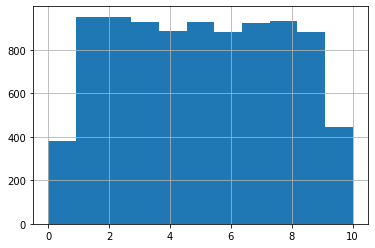

In [8]:
data_clients['Tenure'].hist(bins = 11)

Распределение выглядит как прямоугольник, если не считать крайние значения. Хотя количество клиентов должно уменьшаться с ростом количества недижимости. Так как не указаны единицы измерения, то невозможно понять, что имеется в виду в этом столбце. Было бы неплохо уточнить данные по этому столбцу у заказчика, может быть и потерянные данные нашлись бы.  
Удалять 10% данных будет многовато, поэтому надо как-то из заполнить. Так как про столбец **Tenure** ничего не известно, то для заполнения пропусков попроуем обучать отдельную модель. Возможно даже такое, распределение **Tenure** должно быть прямоугольным, тогда пропущенны только значения 0 и 10.  

Убираем лишние столбцы **RowNumber**,	**CustomerId**,	**Surname**, надеемся, что клиенты уходили не из-за дискриминации по расовой или национальной принадлежности, что могло бы быть отражено в фамилиях ушедших клиентов.

In [9]:
data_clients = data_clients.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Преобразуем категориальные признаки **Geography** и	**Gender** в количественные с помощью прямого кодирования.

In [10]:
data_clients_ohe = pd.get_dummies(data_clients , drop_first= True )

Разделите исходные данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.  

In [11]:
data_clients_tr_val, data_clients_test = train_test_split(data_clients_ohe, test_size=0.2, random_state=12345)
data_clients_train, data_clients_valid = train_test_split(data_clients_tr_val, test_size=0.25, random_state=12345)

Масштабируем количественные признаки **CreditScore**, **Age**, **Balance** и **EstimatedSalary**

In [12]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(data_clients_train[numeric])
data_clients_train[numeric] = scaler.transform(data_clients_train[numeric])
data_clients_valid[numeric] = scaler.transform(data_clients_valid[numeric])
data_clients_test[numeric] = scaler.transform(data_clients_test[numeric])
data_clients_tr_val[numeric] = scaler.transform(data_clients_tr_val[numeric])
data_clients_tr_val.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
454,1.093401,0.017370,6.0,0.811201,1,0,1,-0.753945,0,0,0,0
8307,-0.350657,-0.841565,3.0,0.915286,1,1,1,-1.191821,0,0,0,1
4811,-0.794189,-1.223314,7.0,-1.232442,2,1,0,0.219064,0,0,1,0
1132,-0.247510,-0.173505,NaN,-1.232442,2,1,1,1.248954,0,0,0,1
9640,1.010884,-0.364379,3.0,-1.232442,1,1,0,1.593627,0,0,0,0


# 2. Исследование задачи

#### Заполнение Tenure

Создаем выборки с необходимыми признаками

In [13]:
# определяем функцию, которая будет создавать нужные выборки
def make_tenure(data_cli):
    data_ten = data_cli[data_cli['Tenure'] >= 0]
    features_tenure = data_ten.drop(['Exited', 'Tenure'], axis = 1)
    target_tenure = data_ten['Tenure']
    return features_tenure, target_tenure

In [14]:
features_tenure_train, target_tenure_train = make_tenure(data_clients_train)
features_tenure_valid, target_tenure_valid = make_tenure(data_clients_valid)
features_tenure_test, target_tenure_test = make_tenure(data_clients_test)
features_tenure_tr_val, target_tenure_tr_val = make_tenure(data_clients_tr_val)

Для заполнения **Tenure**, рассмотрим модели случайного леса со следующим диапазоном гиперпараметров:  
* количество деревьев **n_estimators** от 1 до 50  
* максимальная глубина **max_depth** = 30

In [29]:
%%time
table = np.zeros((50, 30, 1))
for i in range(50):
    for j in range (30):
        model_forest = RandomForestClassifier(n_estimators=i+1, max_depth=j+1, random_state=12345, class_weight='balanced')
        model_forest.fit(features_tenure_train, target_tenure_train)
        predictions = model_forest.predict(features_tenure_valid)
        table[i][j][0] = accuracy_score(target_tenure_valid , predictions)
res = table.reshape(50, 30)
print('max accuracy =', np.amax(table))
print('(n_estimators - 1, max_depth - 1) =',np.unravel_index(np.argmax(res, axis=None), res.shape))

max accuracy = 0.11767925561029009
(n_estimators - 1, max_depth - 1) = (24, 13)
CPU times: user 6min 44s, sys: 831 ms, total: 6min 44s
Wall time: 6min 47s


Лучше всего себя показала модель с **n_estimators** = 25 и **max_depth** = 14.  
Но точность составила всего 0.12, что лишь на пару процентов больше, чем если заполнять все **Tenure** случайно или наиболее часто встречающимся значением.  
Если заполнять случайно, то вероятность угадать будет 9%, так как вариантов заполнения 11.  
Если заполнять наиболее часто встречающимся значением, то точность окажется 0.10.

Обучим модель на тренировочной+валидационной выборке и посмотрим, какой будет результат на тестовой выборке

In [23]:
model_forest_25_14 = RandomForestClassifier(n_estimators=25, max_depth=14, random_state=12345, class_weight='balanced')
model_forest_25_14.fit(features_tenure_tr_val, target_tenure_tr_val)
predictions_25_14 = model_forest_25_14.predict(features_tenure_test)
print('accuracy =', accuracy_score(target_tenure_test , predictions_25_14))

accuracy = 0.0970556161395856


Точность составила 0.1, то есть результат стал ещё хуже и сравнял с результатом заполнения наиболее часто встречающимся значением. То есть такая модель не подходит.  

Рассмотрим модель логистической регрессии.

In [24]:
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_tenure_train, target_tenure_train)
predictions = model.predict(features_tenure_valid)
accuracy = accuracy_score(target_tenure_valid , predictions)
print('accuracy =', accuracy)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy = 0.08976464148877943


У логистической регрессии точность ещё меньше (0.09).  
Посмотрим, что будет на тренировочной+валидационной выборке:

In [26]:
model_lg = LogisticRegression(random_state=12345)
model_lg.fit(features_tenure_tr_val, target_tenure_tr_val)
predictions_lg = model_lg.predict(features_tenure_test)
accuracy = accuracy_score(target_tenure_test , predictions_lg)
print('accuracy =', accuracy)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy = 0.11777535441657579


На тренировочной+валидационной выборке модель показала точность 0.12. Такого значения явно не достаточно для зполнения пропусков в столбце **Tenure**.  
Если заполнить не получается, то есть следующие варианты: убирать или столбец **Tenure**, или строки, где **Tenure** не заполнен. В обоих случаях получается примерно одинаковое количество ячеек изначальной таблицы, но так как Tenure является непонятной величиной, возможно даже ненужной, как, например, CustomerId, то уберем столбец **Tenure**.

#### Посроение моедли для ключевого признака **Exited**

In [17]:
# определяем функцию, которая будет создавать нужные выборки
def make_clients(data_cli):
    features_clients = data_cli.drop(['Exited', 'Tenure'], axis = 1)
    target_clients = data_cli['Exited']
    return features_clients, target_clients

Создаем нужные выбоки

In [18]:
features_clients_train, target_clients_train = make_clients(data_clients_train)
features_clients_valid, target_clients_valid = make_clients(data_clients_valid)
features_clients_test, target_clients_test = make_clients(data_clients_test)
features_clients_tr_val, target_clients_tr_val = make_clients(data_clients_tr_val)

Определим соотношение классов

In [19]:
data_clients_ohe['Exited'][data_clients_ohe['Exited'] == 0].count() / data_clients_ohe['Exited'].count()

0.7963

Отношение оставшихся клиентов банка ко всем клиентам банка составило почти 0.8

Рассмотрим модели случайного леса со следующим диапазоном гиперпараметров:  
* количество деревьев **n_estimators** от 1 до 50  
* максимальная глубина **max_depth** = 30

In [20]:
%%time
x = 50
y = 30
table = np.zeros((x, y, 1))
for i in range(x):
    for j in range (y):
        model_forest = RandomForestClassifier(n_estimators=i+1, max_depth=j+1, random_state=12345)
        model_forest.fit(features_clients_train, target_clients_train)
        predictions = model_forest.predict(features_clients_valid)
        table[i][j][0] = f1_score(target_clients_valid , predictions)
res = table.reshape(x, y)
print('max f1_score =', np.amax(table))
print('(n_estimators - 1, max_depth - 1) =',np.unravel_index(np.argmax(res, axis=None), res.shape))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

max f1_score = 0.573268921095008
(n_estimators - 1, max_depth - 1) = (41, 10)
CPU times: user 5min 18s, sys: 1.23 s, total: 5min 20s
Wall time: 5min 24s


Лучше всего себя показала модель с **n_estimators** = 42 и **max_depth** = 11: значение метрики f1_score составило 0.57   

Посмотрим какой результат покажет модель логистической регрессии

In [21]:
model = LogisticRegression(random_state=12345)
model.fit(features_clients_train, target_clients_train)
predictions = model.predict(features_clients_valid)
f1 = f1_score(target_clients_valid , predictions)
print('f1_score =', f1)

f1_score = 0.30451127819548873


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Значение метрики f1_score составило всего лишь 0.3.

### Вывод

Обе модели, случайный лес и логистическая регрессия, показали неудовлетворительные результаты: метрики f1_score показали значения ниже целевого (0.59): 0.57 и 0.3 соответственно. Для улучшения результатов можно попробовать улучшить баланс классов ключевого признака. Использовать будем модель случайного леса, так как она показала результат гораздо лучше, чем модель логистической регрессии.

# 3. Борьба с дисбалансом

#### Балансировка классов

Попробуем сбалансировать классы в модели случайного леса с гиперпараметрами **n_estimators** = 42 и **max_depth** = 11

In [22]:
model_forest_42_11 = RandomForestClassifier(n_estimators=42, max_depth=11, random_state=12345, class_weight='balanced')
model_forest_42_11.fit(features_clients_train, target_clients_train)
predictions_42_11 = model_forest_42_11.predict(features_clients_valid)
print('f1_score =', f1_score(target_clients_valid , predictions_42_11))

f1_score = 0.5863874345549738


Метрика f1_score улучшилась и составила 0.586, но этого все ещё недостаточно

#### Увеличение выборки

Увеличим выборку, в которой ключевой признак **Exited** равен 1.

In [23]:
# определим функция для увеличения количества единиц
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * (repeat+1))
    target_upsampled = pd.concat([target_zeros] + [target_ones] * (repeat+1))

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

Выявим оптимальный коэффициент **repeat**, который показывать во сколько раз надо увеличить выборку с ключевым признаком **Exited**, равным 1.

In [43]:
%%time

table = np.zeros(100)
model_forest = RandomForestClassifier(n_estimators=42, max_depth=11, random_state=12345, class_weight='balanced')
for repeat in range(100):
    features_upsampled, target_upsampled = upsample(features_clients_train, target_clients_train, repeat)
    model_forest.fit(features_upsampled, target_upsampled)
    predictions = model_forest.predict(features_clients_valid)
    table[repeat] = f1_score(target_clients_valid , predictions)
print('max f1_score =', np.amax(table))
print('repeat =', np.argmax(table))

max f1_score = 0.6146341463414633
repeat = 1
CPU times: user 4min 22s, sys: 404 ms, total: 4min 23s
Wall time: 4min 25s


In [48]:
features_upsampled, target_upsampled = upsample(features_clients_train, target_clients_train, 1)
model_forest_42_11 = RandomForestClassifier(n_estimators=42, max_depth=11, random_state=12345, class_weight='balanced')
model_forest_42_11.fit(features_upsampled, target_upsampled)
predictions_42_11 = model_forest_42_11.predict(features_clients_valid)
print('f1_score =', f1_score(target_clients_valid , predictions_42_11))
print('roc_auc =', roc_auc_score(target_clients_valid, predictions_42_11))

f1_score = 0.6146341463414633
roc_auc = 0.7672475318659904


Лучше всего себя показала модель с коэффициентом **repeat** = 1, то ключевую выборку c **Exited** = 1 надо удвоить.  
В этом случае метрика f1_score = 0.61, roc_auc = 0.77.

#### Уменьшение выборки

Уменьшим выборку, в которой ключевой признак **Exited** равен 0.

In [49]:
# определим функцию для уменьшения выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Выявим оптимальное уменьшение выборки

In [50]:
%%time
model_forest = RandomForestClassifier(n_estimators=42, max_depth=11, random_state=12345, class_weight='balanced')
table = np.zeros(19)
for fra in range(1,20):
    features_downsampled, target_downsampled = downsample(features_clients_train, target_clients_train, 1 / fra)
    model_forest.fit(features_downsampled, target_downsampled)
    predictions = model_forest.predict(features_clients_valid)
    table[fra - 1] = f1_score(target_clients_valid , predictions)
print('max f1_score =', np.amax(table))
print('1/fraction-1 =', np.argmax(table))

max f1_score = 0.6005361930294906
1/fraction-1 = 0
CPU times: user 3.48 s, sys: 16 ms, total: 3.5 s
Wall time: 3.5 s


In [52]:
features_downsampled, target_downsampled = downsample(features_clients_train, target_clients_train, 1)
model_forest_0 = RandomForestClassifier(n_estimators=42, max_depth=11, random_state=12345, class_weight='balanced')
model_forest_0.fit(features_downsampled, target_downsampled)
predictions_0 = model_forest_0.predict(features_clients_valid)
print('f1_score =', f1_score(target_clients_valid , predictions_0))
print('roc_auc =', roc_auc_score(target_clients_valid, predictions_0))

f1_score = 0.6005361930294906
roc_auc = 0.745736498182379


Оказывается, что оптимальный результат достагается, если выборку не уменьшать, а просто перемешать. Но в этом случае результаты оказываются хуже, чем в случае уменьшения выборки: метрика f1_score = 0.6, а roc_auc = 0.75

#### Изменение порога

Для выявления оптимального порога будем использовать модель, полученную при увеличении выборки

In [53]:
probabilities_valid = model_forest_42_11.predict_proba(features_clients_valid)
probabilities_one_valid = probabilities_valid[:, 1]
table = np.zeros(100)
for threshold in np.arange(0, 100, 1):
    predicted_valid = probabilities_one_valid > threshold/100
    table[threshold] = f1_score(target_clients_valid, predicted_valid)
print('max f1_score =', np.amax(table))
print('threshold =', np.argmax(table) / 100)

max f1_score = 0.6146341463414633
threshold = 0.5


Оказывается, что изменения порога не требуется, так как порог по умолчанию итак составляет 0.5

### Вывод

При учете дисбаланса классов лучше всего себя показала модель случайного леса с гиперпараметрами **n_estimators** = 42 и **max_depth** = 11, увеличением в два раза выборки ключевого признака **Exited**, равного единице, и со стандартным порогом, равным 0.5.

# 4. Тестирование модели

Тестирование модели случайного леса с гиперпараметрами **n_estimators** = 42 и **max_depth** = 11, увеличеним в два раза выборки ключевого признака **Exited**, равного единице, и со стандартным порогом, равным 0.5.

In [56]:
features_upsampled, target_upsampled = upsample(features_clients_tr_val, target_clients_tr_val, 1)
model_forest_42_11.fit(features_upsampled, target_upsampled)
predictions = model_forest_42_11.predict(features_clients_test)
print('f1_score =', f1_score(target_clients_test , predictions))
print('roc_auc =', roc_auc_score(target_clients_test , predictions))

f1_score = 0.6351648351648351
roc_auc = 0.7767418870250465


# 5. Вывод

Удалось достичь показателя F1-меры не менее 0.59, а именно 0.64 при применении  модели случайного леса с гиперпараметрами **n_estimators** = 42 и **max_depth** = 11, увеличением в два раза выборки ключевого признака **Exited**, равного единице, и со стандартным порогом, равным 0.5.  
Метрика roc_auc незначительно растет от 0.77 до 0.78.
При такой модели получилась следующая матрица ошибок:

In [59]:
confusion_matrix(target_clients_test , predictions)

array([[1379,  194],
       [ 138,  289]])

Правильно определены клиенты, которые ушли - 289, которые остались - 1379.  
Ошибочно определены клиенты, как ушедшие - 194.  
Ошибочно определены клиенты, как оставшиеся - 138.